# Lab. 3: GD, Newton methods and BFGS

## Introduction

#### <u>The goal of this laboratory is to study the application of local search algorithms on different benchmark functions.</u>

We will study three methods:
- *Gradient Descent*
- *Newton methods*
- *BFGS*

Moreover, we will study how their parameters change the behavior of these algorithms.

---

Getting started: the following code cell contains the core functions that we will use. Hence, **remember to run it every time the runtime is reconnected**.

It contains the three local search algorithms and a wrapper class called *OptFun* for the benchmark function.
As regards the *OptFun* class, the constructor takes as input a benchmark function (we will see later what functions are available). The relevant methods  are 4:
1.   *Minima*: return the minimum of the function. The position can be obtained by the parameter *position* and the function value from the *score* parameter.
2.   *Bounds*: returns where the function is defined
3.   *Heatmap*: show a heatmap of the function highlighting the points visited by the local search (use with 2d function)
4.   *plot*: show the trend of the points visited by the local search (use with 1d function)
5.   *trend*: show the best points find during the optmization process.

Each instance of *OptFun* stores the history of the point at which the function has been evaluated. The history is never cleaned and can be obtained through *OptFun.history*. Hence, if you reuse the class instance remember to clean the history (*OptFun.history = list()*).

---

The benchmark functions available comes from the *benchmark_functions* library (imported as *bf*).
Example of the functions that can be used are the *Hypersphere*, the *Rastrign* the *DeJong5* and the Keane.
The complete list of functions available can be found at this [link](https://gitlab.com/luca.baronti/python_benchmark_functions) or printing *dir(bf)*.

#### Base code to run every time the runtime is reconnected

In [ ]:
# from scipy.misc import derivative
import inspect
from copy import deepcopy
from typing import Optional

import benchmark_functions as bf
import numdifftools as nd
import numpy as np
from matplotlib import pyplot as plt
from numpy.typing import NDArray
from scipy.optimize import OptimizeResult, approx_fprime, minimize

plt.rcParams["figure.figsize"] = (22, 8)

In [104]:
class OptFun:
    def __init__(self, wf: bf.BenchmarkFunction) -> None:
        self.f = wf
        self.history: list[list[float]] = []

    def __call__(self, x0: list[float]) -> float:
        self.history.append(deepcopy(x0))
        return self.f(x0)  # type: ignore

    @property
    def name(self) -> str:
        return self.f.name()

    def minima(self) -> list[bf.fil.Optimum]:
        """
        Returns a list of Optimum objects of the known global minima. If there aren't any minima, an empty list value will be returned instead;

        Returns:
        - List of objects of class "benchmark_functions.functions_info_loader.Optimum"
        - For each object:
          - Access to 'position' parameter to get the axis values
          - Access to 'score' parameter to get the value of the function
        """
        return self.f.minima()

    def bounds(self) -> list[tuple[float, float]]:
        return self._convert_bounds(self.f.suggested_bounds())

    def plot(self, fn: Optional[str] = None) -> None:
        plt.clf()
        ax1: plt.Axes
        ax2: plt.Axes
        f, (ax1, ax2) = plt.subplots(1, 2)
        f.suptitle("Benchmark Function: " + self.name)

        # heatmap
        bounds_lower, bounds_upper = self.f.suggested_bounds()
        x = np.linspace(bounds_lower[0], bounds_upper[0], 100)
        if self.f.n_dimensions() > 1:
            y = np.linspace(bounds_lower[1], bounds_upper[1], 100)
            X, Y = np.meshgrid(x, y)
            Z = np.asarray(
                [
                    [self.f((X[i][j], Y[i][j])) for j in range(len(X[i]))]
                    for i in range(len(X))
                ]
            )
        else:
            raise ValueError("Function has only one dimension")
        ax1.contour(x, y, Z, 15, linewidths=0.5, colors="k")
        contour = ax1.contourf(x, y, Z, 15, cmap="viridis", vmin=Z.min(), vmax=Z.max())
        ax1.set_xlabel("x")
        ax1.set_ylabel("y")
        ax1.set_title("Heatmap")
        cbar = plt.colorbar(contour, ax=ax1)
        cbar.set_label("z")
        if len(self.history) > 0:  # plot points
            xdata = [x[0] for x in self.history]
            ydata = [x[1] for x in self.history]

            min_point: list[float] = self.minima()[0].position  # type: ignore
            ax1.plot(min_point[0], min_point[1], "Xb", markersize=13)
            ax1.plot(xdata[0], ydata[0], "Xr", markersize=13)
            ax1.plot(xdata, ydata, "or-", markersize=5, linewidth=1.5)
            ax1.plot(xdata[-1], ydata[-1], "Pr", markersize=13)

        # convergence
        values = [self.f(v) for v in self.history]
        min: float = self.f.minima()[0].score  # type: ignore
        ax2.plot(values)
        ax2.axhline(min, color="r", label="optimum")
        ax2.set_xlabel("Iterations")
        ax2.set_ylabel("f(x)")
        ax2.set_title("Function Evaluation")
        ax2.legend()

        if fn is not None:
            plt.savefig(fn, dpi=400)
        plt.show()

    def _convert_bounds(
        self, bounds: tuple[list[float], list[float]]
    ) -> list[tuple[float, float]]:
        new_bounds = []
        for i in range(len(bounds[0])):
            new_bounds.append((bounds[0][i], bounds[1][i]))
        return new_bounds

    def current_calls(self):
        return len(self.history)

    def gradient(self, x: list[float]) -> NDArray[np.float64]:
        return approx_fprime(x, self.f, epsilon=1.4901161193847656e-08)  # type: ignore


def gradient_descent(
    f: OptFun,
    x0: list[float],
    learn_rate: float,
    n_iter: int = 50,
    tolerance: float = 1e-06,
) -> list[float]:
    x = x0
    f.history.append([v for v in x])
    for _ in range(n_iter):
        diff: NDArray[np.float64] = -learn_rate * f.gradient(x)
        if np.abs(diff).all() <= tolerance:
            break
        x += diff
        f.history.append([v for v in x])

    return x


def newton_method(
    f: OptFun, x0: list[float], n_iter: int = 50, tolerance: float = 1e-06
) -> list[float]:
    x: NDArray[np.float64] = np.array(x0)
    f.history.append(x.copy().tolist())
    f_jacob = nd.Jacobian(f.f)
    f_hess = nd.Hessian(f.f)
    for _ in range(n_iter):
        JA = f_jacob(x)
        HA = np.linalg.inv(f_hess(x))
        diff = -1 * np.dot(JA, HA)[0]
        if np.all(np.abs(diff) <= tolerance):
            break
        x += diff
        f.history.append(x.copy().tolist())
    return x.tolist()


def bfgs(f: OptFun, x0: list[float], eps: float, maxiter: int) -> OptimizeResult:
    """
    Optimizes a function by using the BFGS algorithm.

    - f: function to optimize, an instance of OptFun
    - x0: starting point for the search process
    - eps: step size for the update of the jacobian
    - maxiter: maximum number of iterations
    """
    return minimize(
        f,
        x0,
        method="BFGS",
        jac=None,
        options={
            "gtol": 1e-6,
            "norm": float("inf"),
            "eps": eps,
            "maxiter": maxiter,
            "disp": False,
            "return_all": True,
            "finite_diff_rel_step": None,
        },
    )

In [ ]:
def printClassInitArgs(class_obj: bf.BenchmarkFunction) -> None:
    print(f"{class_obj.name()}")
    signature = inspect.signature(class_obj.__init__).parameters
    print("-------------------------------")
    for name, parameter in signature.items():
        if name != "opposite":
            print("Name: ", name, "\nDefault value:", parameter.default)
            # print("Annotation:", parameter.annotation, "\nKind:", parameter.kind)
            print("-------------------------------")

# Exercises

#### Solve the following exercises, and answer these questions at the end:

- What is the difference in search cost (the number of function/derivative evaluations) between these methods?
- Comparing these methods to the ones of the first laboratory, are they faster? Or find the optimal more efficiently?

In [ ]:
# BE AWARE: check the arguments each benchmark function takes
# if you're not sure, you can check the arguments by using the printClassInitArgs function


printClassInitArgs(bf.Hypersphere())

## Exercise 1/3: GRADIENT DESCENT
In this first exercise, we will focus on the Gradient Descent algorithm.
The gradient descent function parameters are
1.   *f*: the function to minimize
2.   *x0*: the starting point
3.   *learn_rate*: the learning rate
4.   *n_iter*: maximum number of iterations
5.   *tolerance*: the tolerance for finding the optimum (minimum step to move towards the optimum, if the step is lower than this threshold, the search stops)

### Questions
- How does the Learning Rate influence optimization?
- How does tolerance influence the search?
- Are the effects of these parameters the same across different functions?

In [ ]:
bench_func = bf.Hypersphere()

start_points = [[-2.0, -2.0], [2.0, 2.0]]
learning_rates = [0.75, 0.01, 1e-3, 1e-4]
n_iters = [10000]
tolerance = 1e-03

for x0 in start_points:
    for lr in learning_rates:
        for n_iter in n_iters:
            func = OptFun(bench_func)
            print("Function:", func.name)
            print("Starting point:", x0)
            print("Learning rate:", lr)
            print("Number of iterations:", n_iter)
            print("Function minimum point:", func.minima()[0].position)
            print("Function minimum value:", func.minima()[0].score)

            res = gradient_descent(func, x0, lr, n_iter, tolerance)
            print("Gradient descent minimum point:", res)
            print("Gradient descent minimum value:", func(res))
            print("Gradient descent function evaluations:", func.current_calls() - 1)
            func.plot()

In [ ]:
bench_func = bf.Rosenbrock()

start_points = [[-2.0, -2.0], [2.0, 2.0]]
learning_rates = [0.01, 0.001]
n_iters = [10000]
tolerance = 1e-06

for x0 in start_points:
    for lr in learning_rates:
        for n_iter in n_iters:
            func = OptFun(bench_func)
            print("Function:", func.name)
            print("Starting point:", x0)
            print("Learning rate:", lr)
            print("Number of iterations:", n_iter)
            print("Function minimum point:", func.minima()[0].position)
            print("Function minimum value:", func.minima()[0].score)

            res = gradient_descent(func, x0, lr, n_iter, tolerance)
            print("Gradient descent minimum point:", res)
            print("Gradient descent minimum value:", func(res))
            print("Gradient descent function evaluations:", func.current_calls() - 1)
            func.plot()

In [ ]:
bench_func = bf.Rastrigin(2)

start_points = [[-4.5, -4.5], [0.5, 0.5]]
learning_rates = [0.001]
n_iters = [10000]
tolerance = 1e-06

for x0 in start_points:
    for lr in learning_rates:
        for n_iter in n_iters:
            func = OptFun(bench_func)
            print("Function:", func.name)
            print("Starting point:", x0)
            print("Learning rate:", lr)
            print("Number of iterations:", n_iter)
            print("Function minimum point:", func.minima()[0].position)
            print("Function minimum value:", func.minima()[0].score)

            res = gradient_descent(func, x0, lr, n_iter, tolerance)
            print("Gradient descent minimum point:", res)
            print("Gradient descent minimum value:", func(res))
            print("Gradient descent function evaluations:", func.current_calls() - 1)
            func.plot()

Important  note: learning rate crucial not only for the convergence of the algorithm but also for the stability of the algorithm(too high learning rate can lead to overflow).

## Exercise 2/3: NEWTON METHOD
In this exercise, we will see the Newton method.
The Newton Method function parameters are
1.   *f*: the function to minimize
2.   *x0*: the starting point
3.   *n_iter*: maximum number of iterations
4.   *tolerance*: the tolerance for finding the optimum (minimum step to move towards the optimum, if the step is lower than this threshold, the search stops)

### Questions
- Is it faster to converge with respect to GD?
- How does tolerance influence the search?
- Are the results similar across different functions?

Function: Martin and Gaddy
Starting point: [20.0, -20.0]
Number of iterations: 1000
Function minimum point: [5.0, 5.0]
Function minimum value: 0.0
Newton method minimum point: [4.999999999999858, 4.9999999999990195]
Newton method minimum value: 8.430223419492526e-25
Newton method function evaluations: 2


<Figure size 2200x800 with 0 Axes>

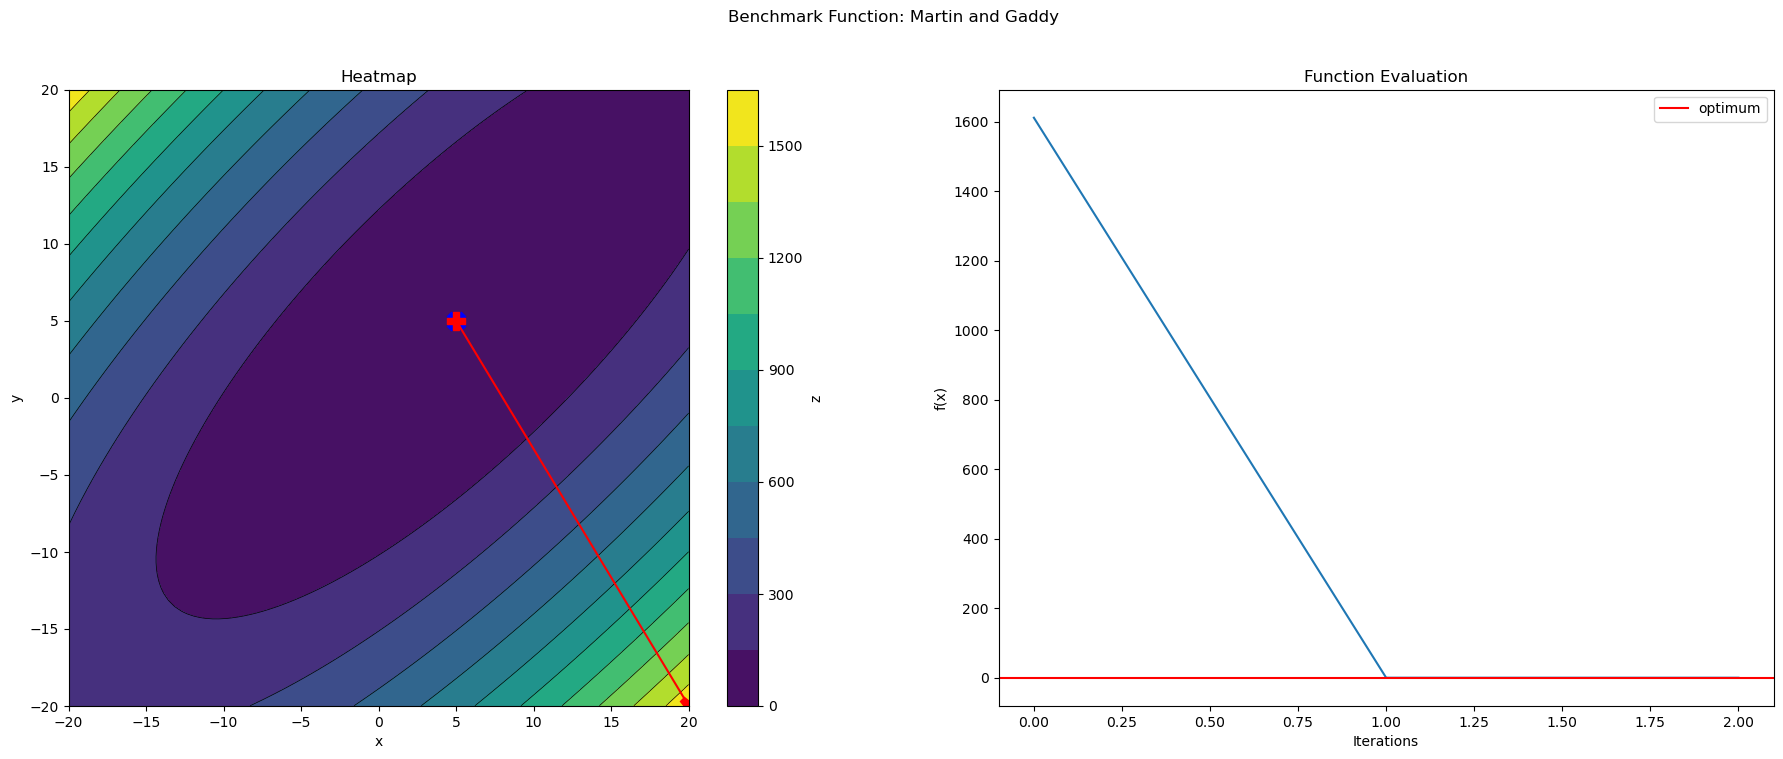

Function: Martin and Gaddy
Starting point: [20.0, -20.0]
Number of iterations: 10000
Function minimum point: [5.0, 5.0]
Function minimum value: 0.0
Newton method minimum point: [4.999999999999858, 4.9999999999990195]
Newton method minimum value: 8.430223419492526e-25
Newton method function evaluations: 2


<Figure size 2200x800 with 0 Axes>

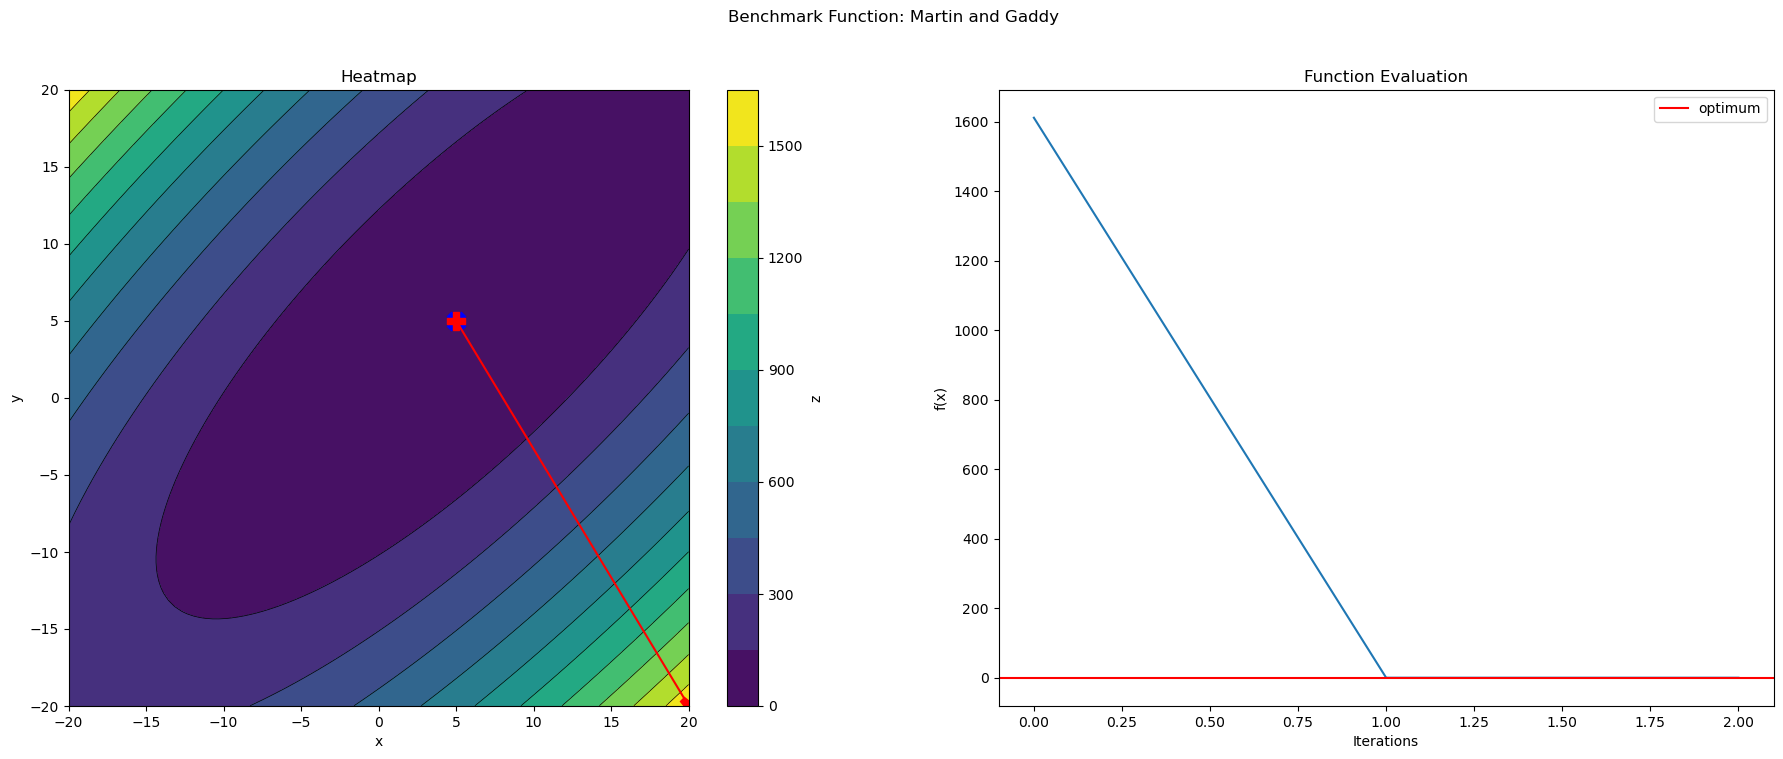

Function: Martin and Gaddy
Starting point: [-10.0, -10.0]
Number of iterations: 1000
Function minimum point: [5.0, 5.0]
Function minimum value: 0.0
Newton method minimum point: [4.999999999999904, 4.999999999999904]
Newton method minimum value: 4.089454932665725e-27
Newton method function evaluations: 2


<Figure size 2200x800 with 0 Axes>

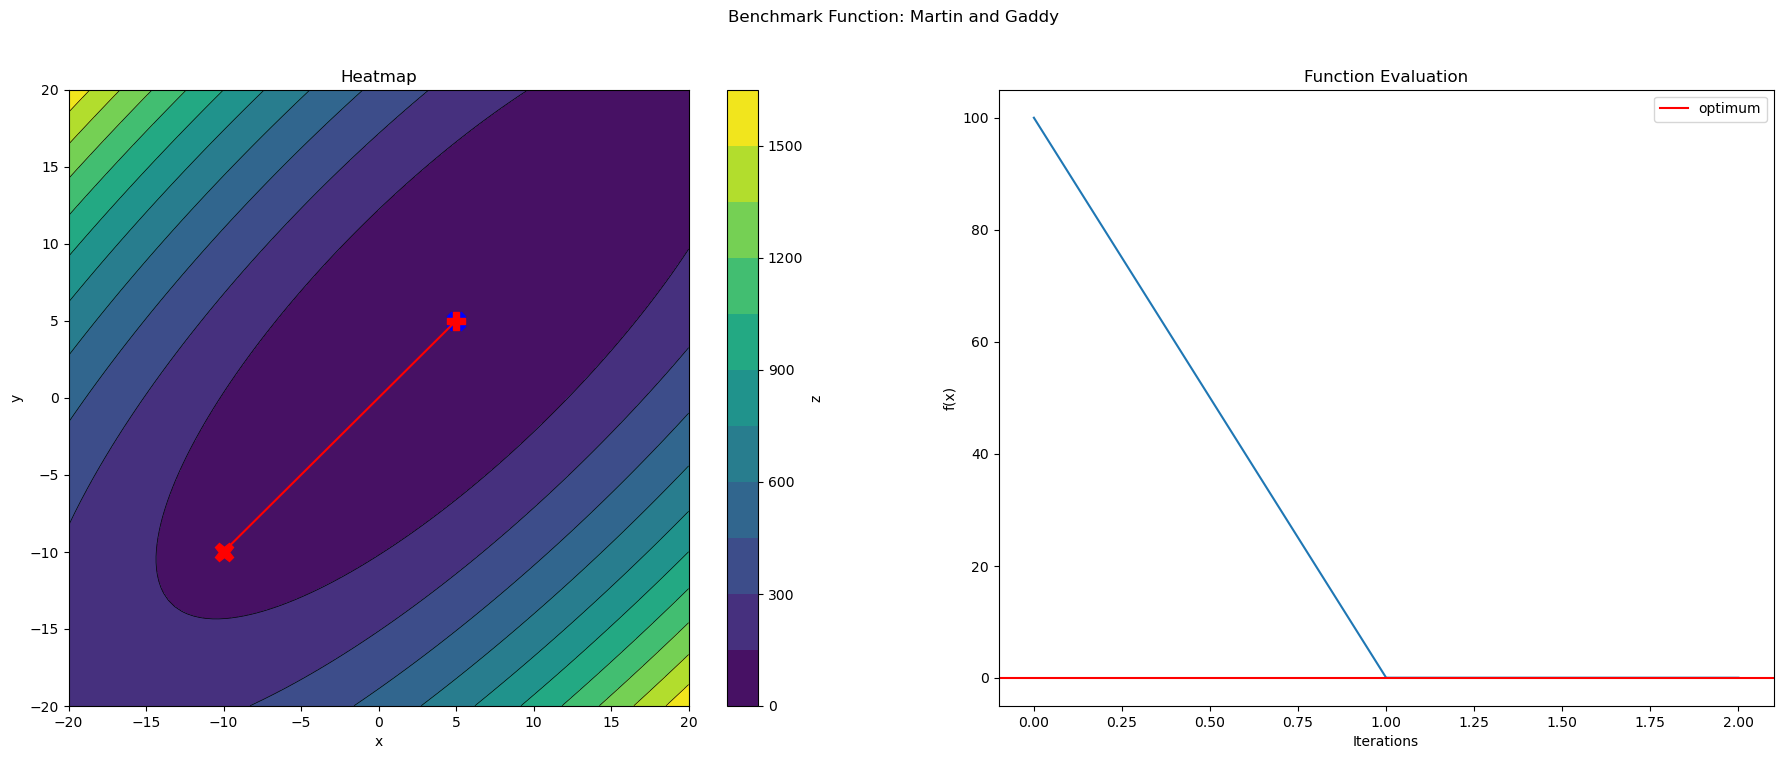

Function: Martin and Gaddy
Starting point: [-10.0, -10.0]
Number of iterations: 10000
Function minimum point: [5.0, 5.0]
Function minimum value: 0.0
Newton method minimum point: [4.999999999999904, 4.999999999999904]
Newton method minimum value: 4.089454932665725e-27
Newton method function evaluations: 2


<Figure size 2200x800 with 0 Axes>

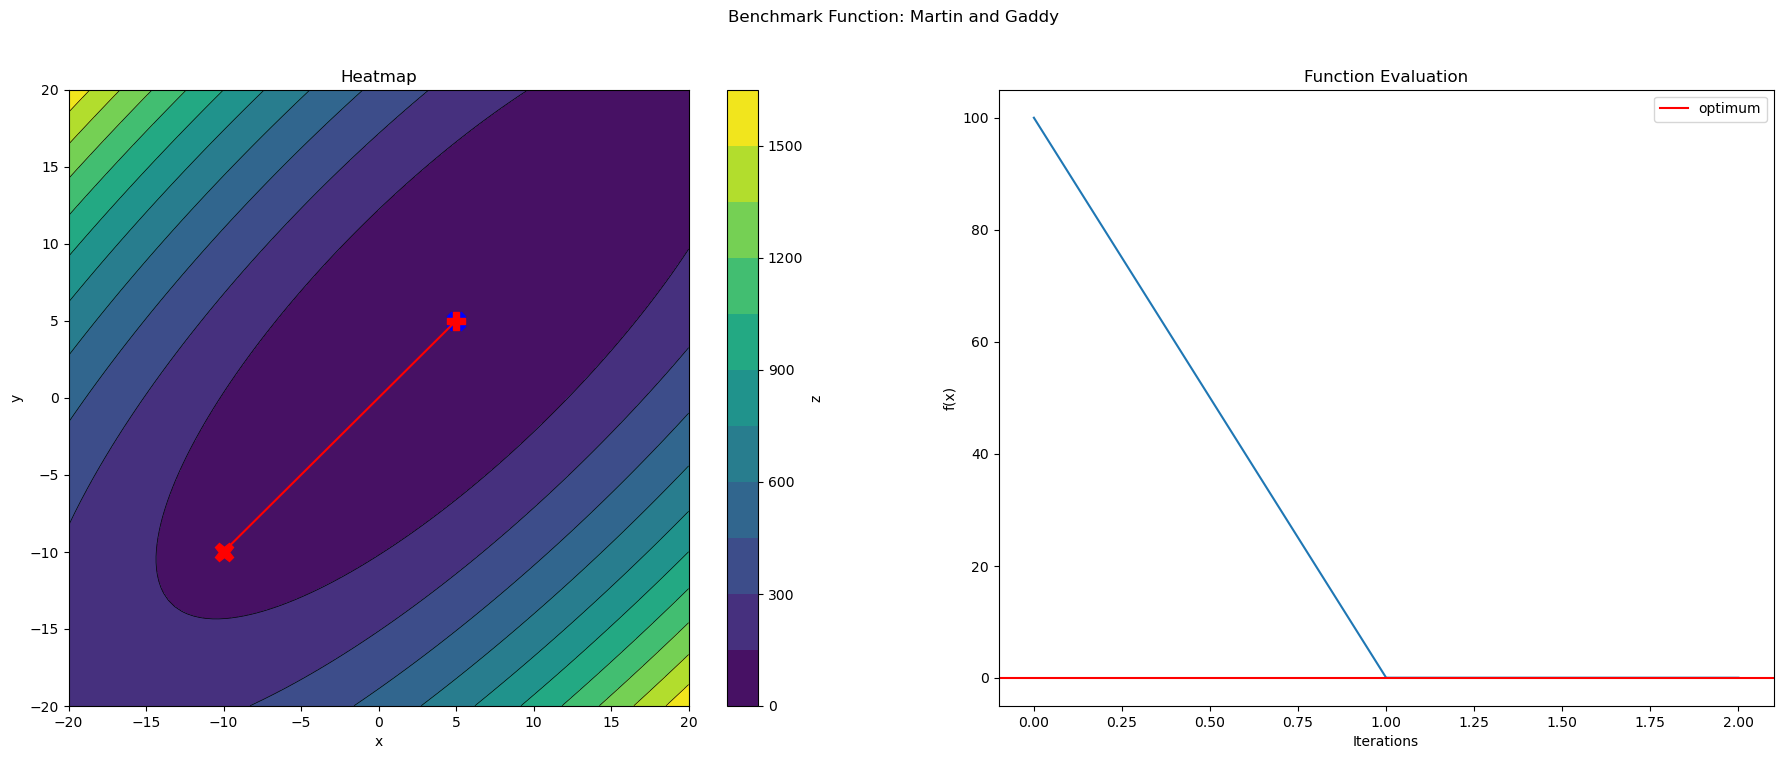

-----------------------------


In [108]:
bench_func = bf.MartinGaddy()

start_points = [[20.0, -20.0], [-10.0, -10.0]]
n_iters = [1000, 10000]
tolerance = 1e-09

for x0 in start_points:
    for n_iter in n_iters:
        func = OptFun(bench_func)
        print("Function:", func.name)
        print("Starting point:", x0)
        print("Number of iterations:", n_iter)
        print("Function minimum point:", func.minima()[0].position)
        print("Function minimum value:", func.minima()[0].score)

        res = newton_method(func, x0, n_iter, tolerance)
        print("Newton method minimum point:", res)
        print("Newton method minimum value:", func(res))
        print("Newton method function evaluations:", func.current_calls() - 1)
        func.plot()

print("-----------------------------")

Function: Rosenbrock
Starting point: [2.0, 2.0]
Number of iterations: 1000
Function minimum point: [1.0, 1.0]
Function minimum value: 0.0
Newton method minimum point: [1.000000000000029, 1.0000000000000582]
Newton method minimum value: 8.461026246561115e-28
Newton method function evaluations: 6


<Figure size 2200x800 with 0 Axes>

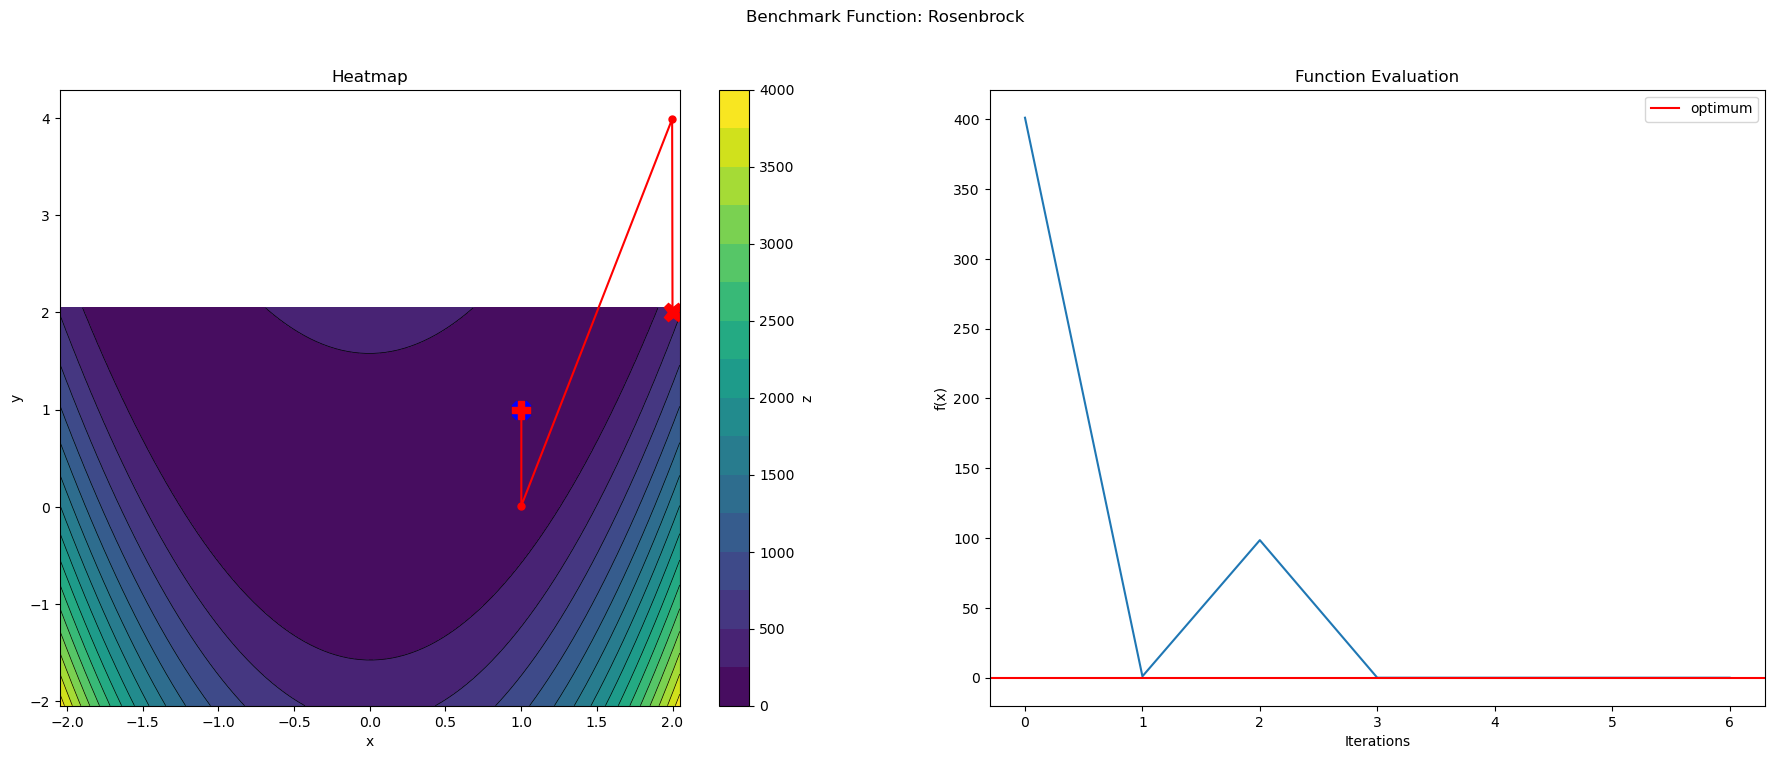

Function: Rosenbrock
Starting point: [2.0, 2.0]
Number of iterations: 10000
Function minimum point: [1.0, 1.0]
Function minimum value: 0.0
Newton method minimum point: [1.000000000000029, 1.0000000000000582]
Newton method minimum value: 8.461026246561115e-28
Newton method function evaluations: 6


<Figure size 2200x800 with 0 Axes>

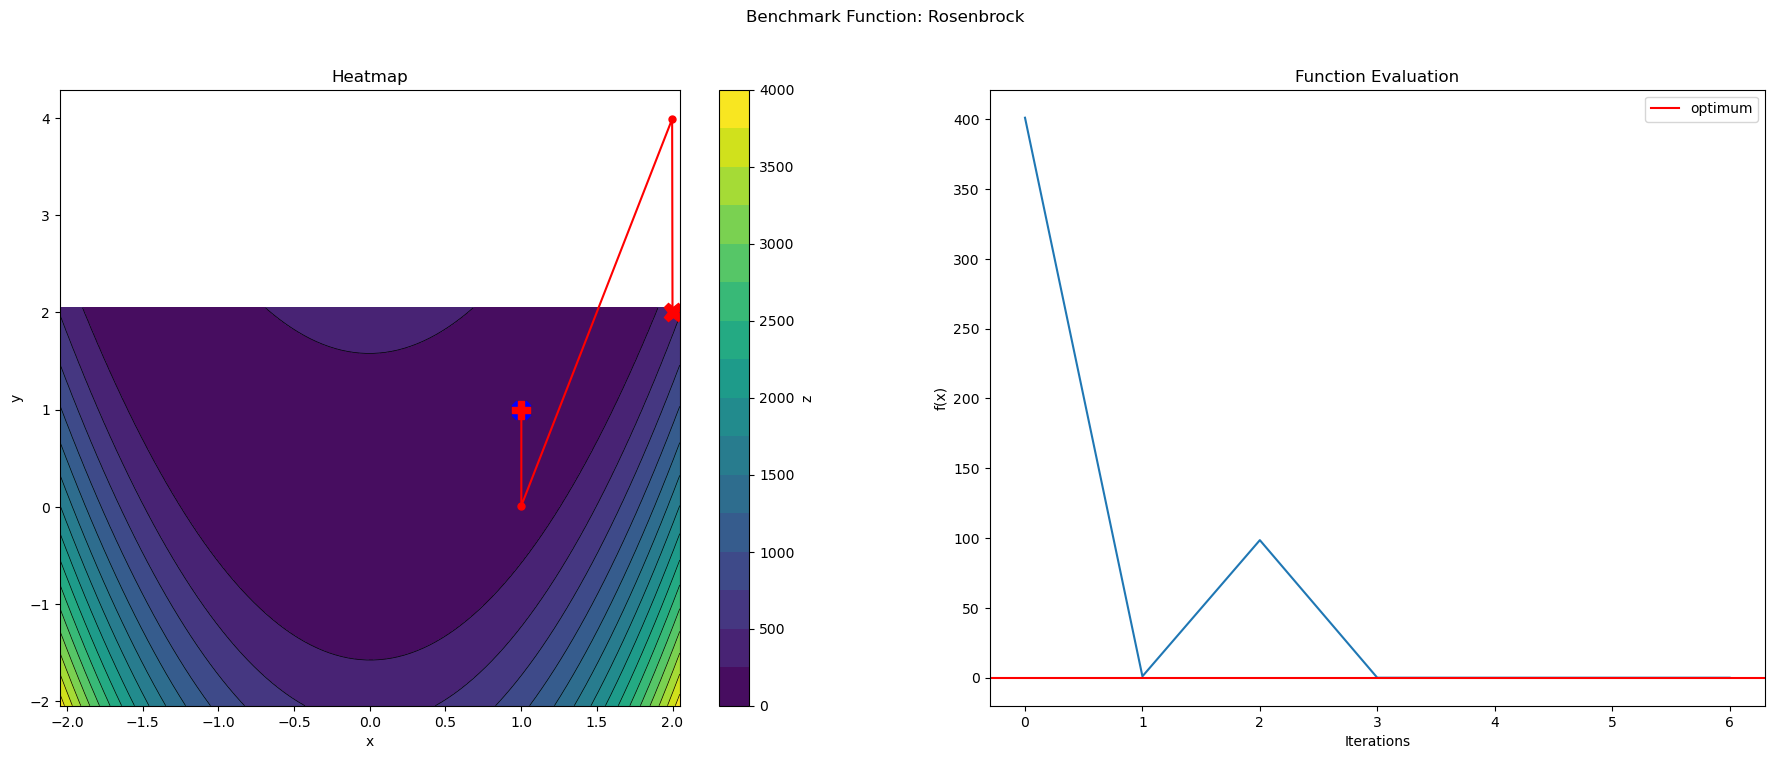

Function: Rosenbrock
Starting point: [-1.0, 1.5]
Number of iterations: 1000
Function minimum point: [1.0, 1.0]
Function minimum value: 0.0
Newton method minimum point: [0.9999999999999777, 0.9999999999985337]
Newton method minimum value: 2.021066927132747e-22
Newton method function evaluations: 7


<Figure size 2200x800 with 0 Axes>

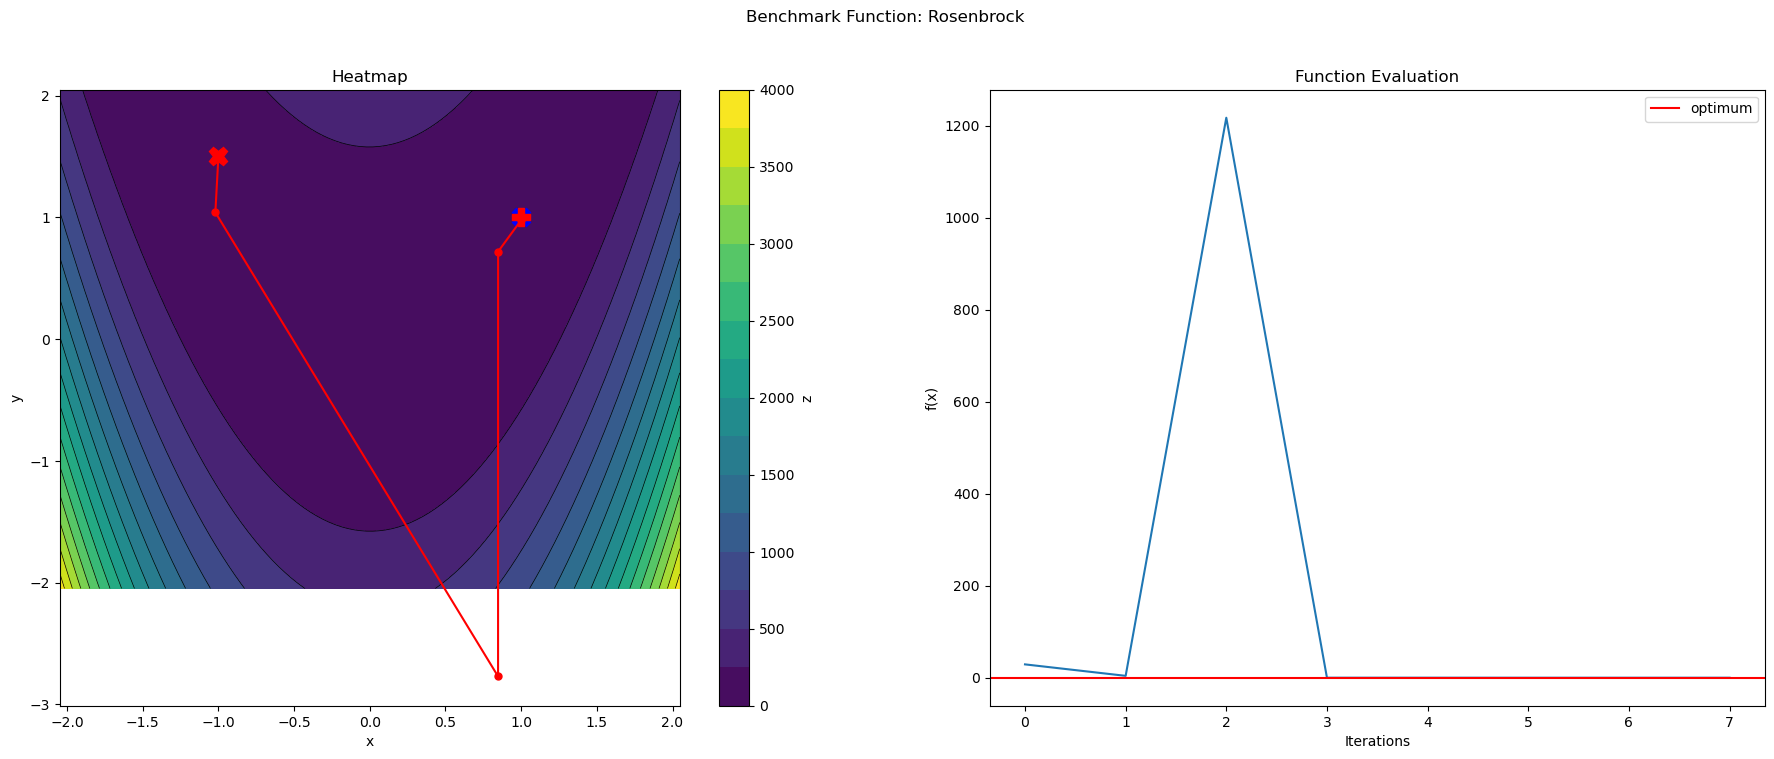

Function: Rosenbrock
Starting point: [-1.0, 1.5]
Number of iterations: 10000
Function minimum point: [1.0, 1.0]
Function minimum value: 0.0
Newton method minimum point: [0.9999999999999777, 0.9999999999985337]
Newton method minimum value: 2.021066927132747e-22
Newton method function evaluations: 7


<Figure size 2200x800 with 0 Axes>

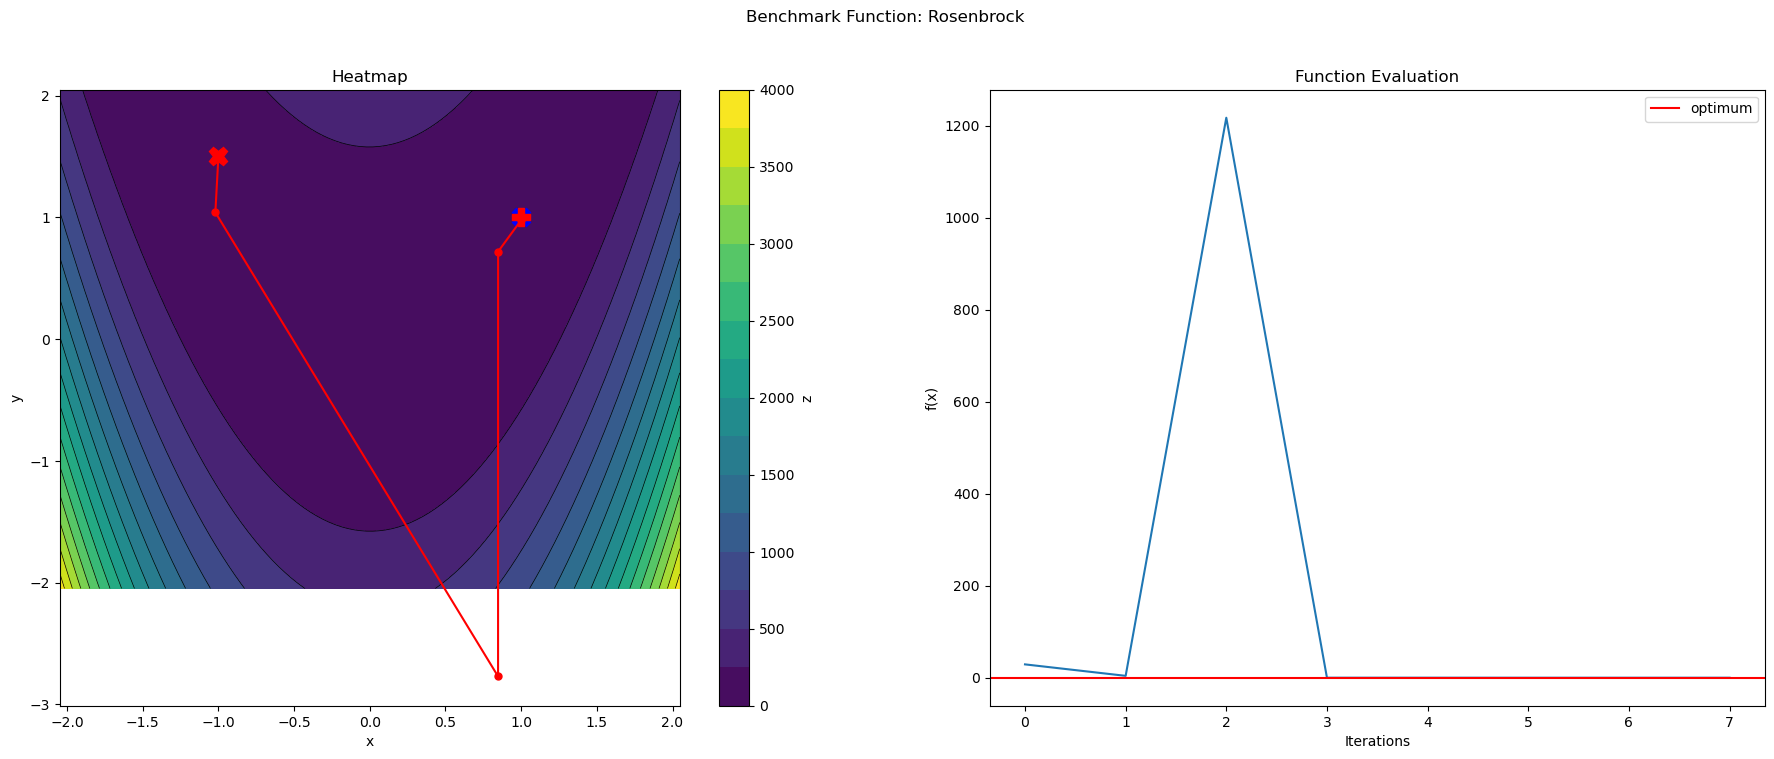

-----------------------------


In [102]:
bench_func = bf.Rosenbrock()

start_points = [[2.0, 2.0], [-1.0, 1.5]]
n_iters = [1000, 10000]
tolerance = 1e-09

for x0 in start_points:
    for n_iter in n_iters:
        func = OptFun(bench_func)
        print("Function:", func.name)
        print("Starting point:", x0)
        print("Number of iterations:", n_iter)
        print("Function minimum point:", func.minima()[0].position)
        print("Function minimum value:", func.minima()[0].score)

        res = newton_method(func, x0, n_iter, tolerance)
        print("Newton method minimum point:", res)
        print("Newton method minimum value:", func(res))
        print("Newton method function evaluations:", func.current_calls() - 1)
        func.plot()

print("-----------------------------")

## Exercise 3/3: BFGS OPTIMIZATION
In this exercise, we will focus on the BFGS optimization algorithm.
The BFGS function parameters are
1.   *f*: the function to minimize
2.   *x0*: the starting point
3.   *eps*: step size for the update of the jacobian
4.   *max_iter*: maximum number of iterations

### Questions
- What does it happen by varying these parameters?
- How do they influence the evolution process?
- What is the difference between BFGS and L-BFGS? Hint: you have to change the BFGS function, calling the right method to minimize. See [here](https://docs.scipy.org/doc/scipy/reference/optimize.minimize-lbfgsb.html#optimize-minimize-lbfgsb) the parameters available.

Function: Rosenbrock
Starting point: [-1.5, -1.5]
Epsilon: 0.01
Number of iterations: 1000
Function minimum point: [1.0, 1.0]
Function minimum value: 0.0
BFGS minimum point: [0.79540574 0.6311508 ]
BFGS minimum value: 0.042089696403095005
BFGS function evaluations: 308


<Figure size 2200x800 with 0 Axes>

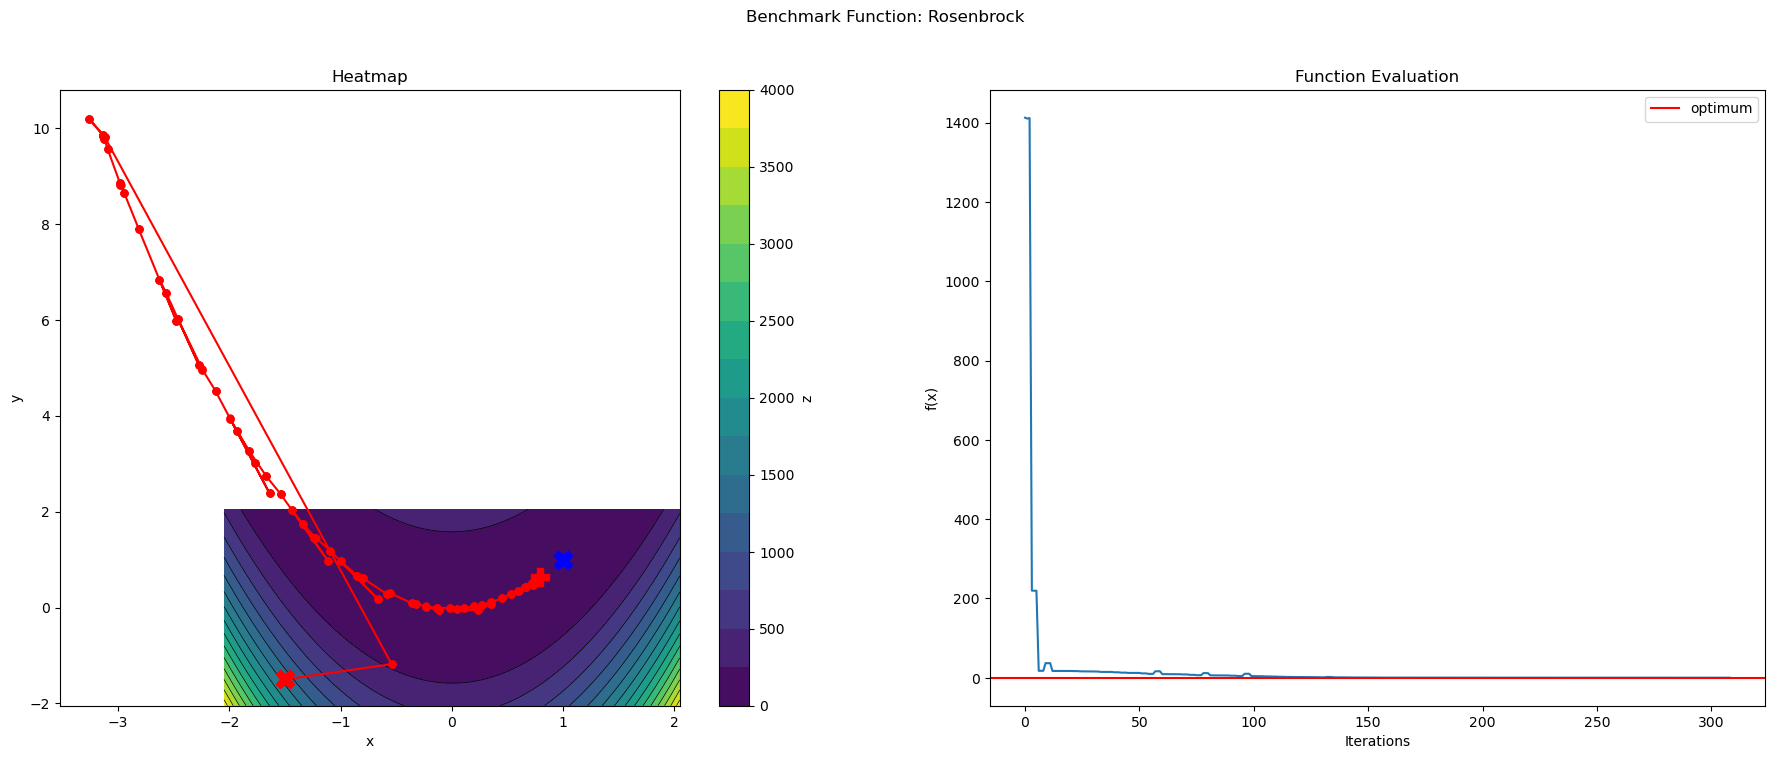

Function: Rosenbrock
Starting point: [2.0, 2.0]
Epsilon: 0.01
Number of iterations: 1000
Function minimum point: [1.0, 1.0]
Function minimum value: 0.0
BFGS minimum point: [0.79386173 0.62971645]
BFGS minimum value: 0.04251798617084778
BFGS function evaluations: 92


<Figure size 2200x800 with 0 Axes>

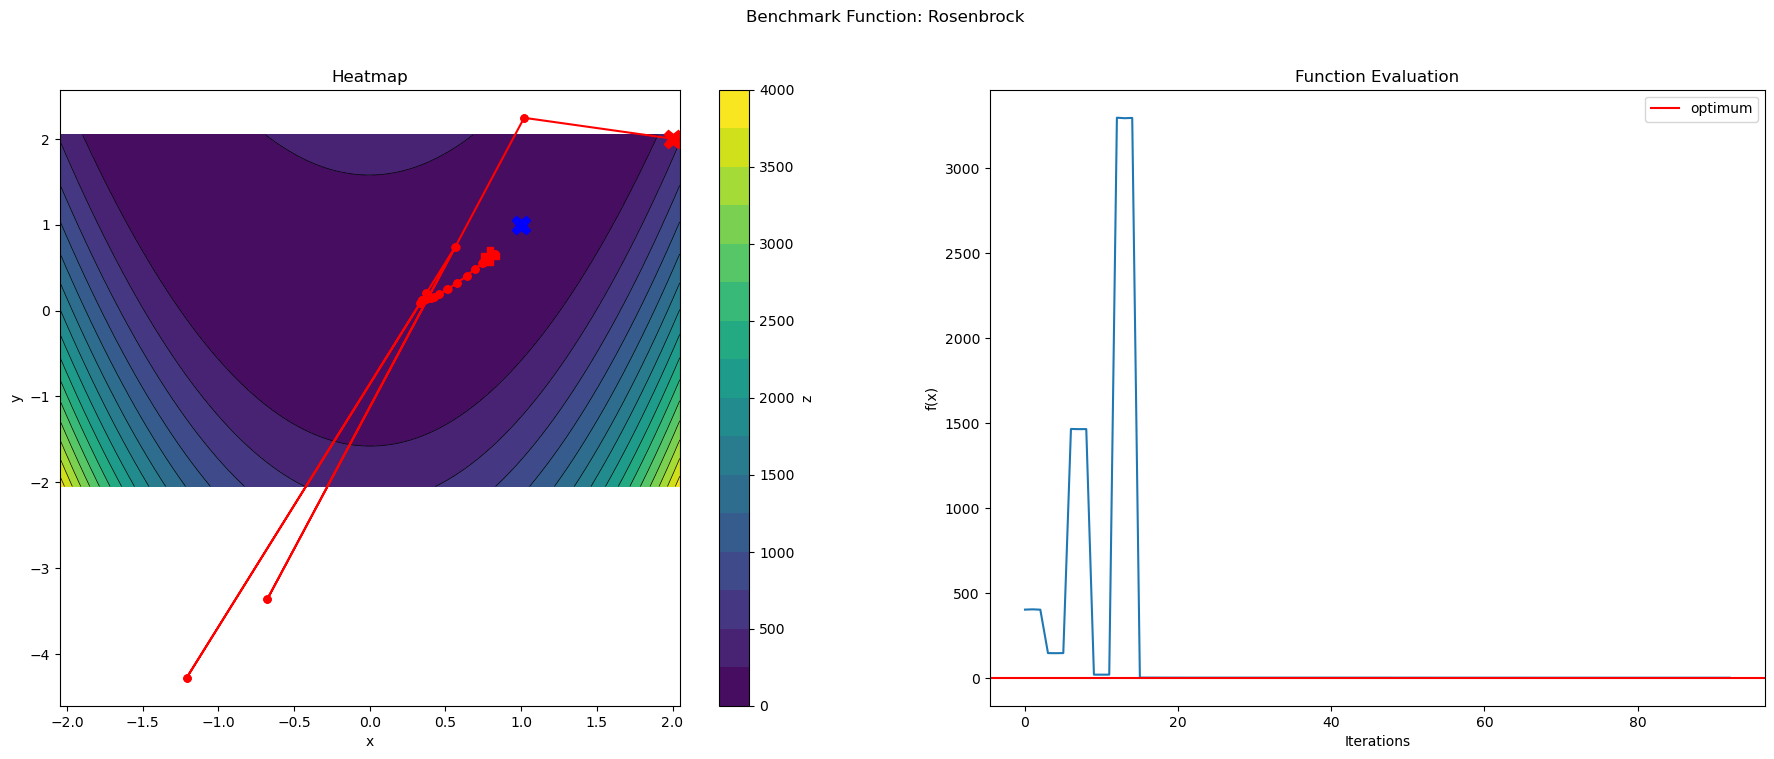

-----------------------------


In [105]:
bench_func = bf.Rosenbrock()

start_points = [[-1.5, -1.5], [2.0, 2.0]]
epsilons = [0.01]
n_iters = [1000]
tolerance = 1e-6

for x0 in start_points:
    for eps in epsilons:
        for n_iter in n_iters:
            func = OptFun(bench_func)
            print("Function:", func.name)
            print("Starting point:", x0)
            print("Epsilon:", eps)
            print("Number of iterations:", n_iter)
            print("Function minimum point:", func.minima()[0].position)
            print("Function minimum value:", func.minima()[0].score)

            res = bfgs(func, x0, lr, n_iter)
            print("BFGS minimum point:", res.x)
            print("BFGS minimum value:", res.fun)
            print("BFGS function evaluations:", func.current_calls() - 1)
            func.plot()


print("-----------------------------")

## Final questions
- What is the difference in search cost (the number of function/derivative evaluations) between these methods?
- Comparing these methods to the ones of the first laboratory, are they faster? Or find the optimal more efficiently?  